### Download data

In [2]:
import requests
url = 'https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip'
response = requests.get(url, verify=True)
with open('./cassavaleafdata.zip', 'wb') as f:
    f.write(response.content)

c:\Users\ADMIN\anaconda3\envs\aio_exercise\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Unzip

In [3]:
import zipfile
import os

# Specify the path to your zip file and the extraction folder
zip_file_path = "../Week_1_CNN/cassavaleafdata.zip"  # Replace with your .zip file path
# Replace with your desired folder path
extract_to_path = "../Week_1_CNN/data"

# Ensure the extraction folder exists
os.makedirs(extract_to_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Files extracted to: ../Week_1_CNN/data


### Read dataset

In [14]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [11]:
path = './data/cassavaleafdata/'
data_paths = {
    'train': path + 'train',
    'valid': path + 'validation',
    'test': path + 'test'
}

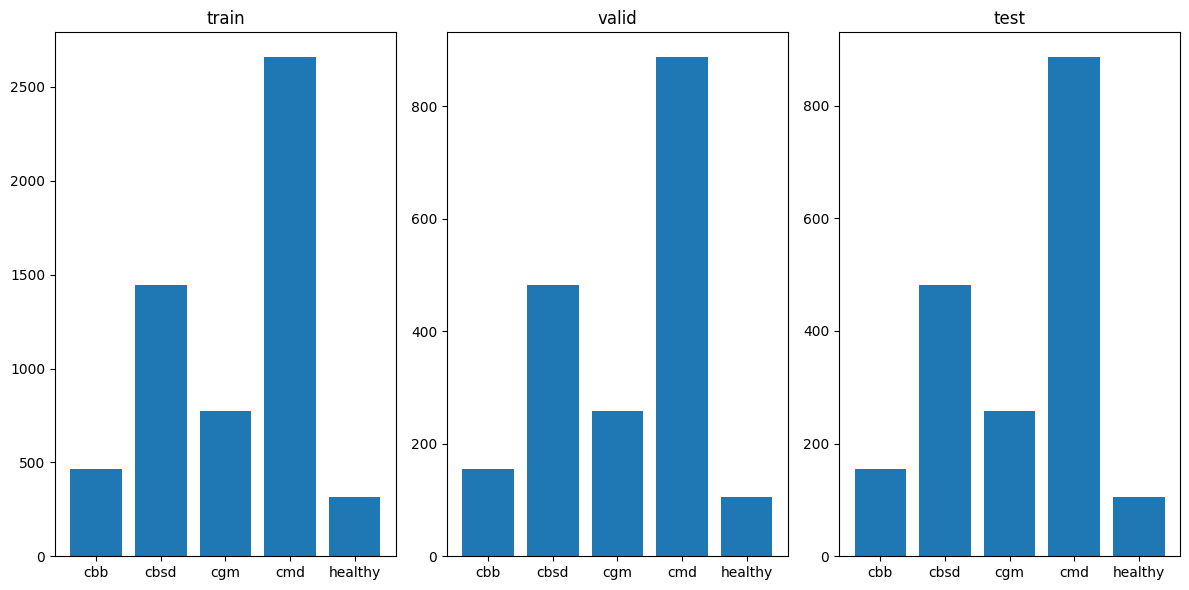

In [12]:
from imutils import paths

def show_labels(data_paths):
    fig, ax = plt.subplots(1, len(data_paths), figsize=(12, 6))
    for idx, (key, sub_dir) in enumerate(data_paths.items()):
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(key)
    plt.tight_layout()
    plt.show()


show_labels(data_paths)

In [13]:
labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

### Preprocessing

In [17]:
def loader(path):
    return Image.open(path)


img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,  # choose 
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

### Data Loader

In [18]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [23]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,
                               kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.avgpool2(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x

In [24]:
num_classes = len(train_data.classes)
lenet_model = LeNetClassifier(num_classes)
summary(lenet_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.20
Params size (MB): 9.02
Estimated Total Size (MB): 11.48
----------------------------------------------------------------


In [25]:
import time


def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0 # number of correct predictions, total number of samples
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # reset grad

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward() # gradient of loss
        optimizer.step() # update params based on above gradient
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [26]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())
    
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [29]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(
        lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(
        lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_cassava_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(
        save_model + '/lenet_cassava_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy    0.437
-----------------------------------------------------------
| End of epoch   1 | Time: 67.83s | Train Accuracy    0.458 | Train Loss    1.400 | Valid Accuracy    0.470 | Valid Loss    1.353 
-----------------------------------------------------------
| epoch   2 |    10/   12 batches | accuracy    0.471
-----------------------------------------------------------
| End of epoch   2 | Time: 71.21s | Train Accuracy    0.250 | Train Loss    1.357 | Valid Accuracy    0.517 | Valid Loss    1.353 
-----------------------------------------------------------
| epoch   3 |    10/   12 batches | accuracy    0.479
-----------------------------------------------------------
| End of epoch   3 | Time: 65.32s | Train Accuracy    0.417 | Train Loss    1.341 | Valid Accuracy    0.476 | Valid Loss    1.322 
-----------------------------------------------------------
| epoch   4 |    10/   12 batches | accuracy    0.481
-------------------------------

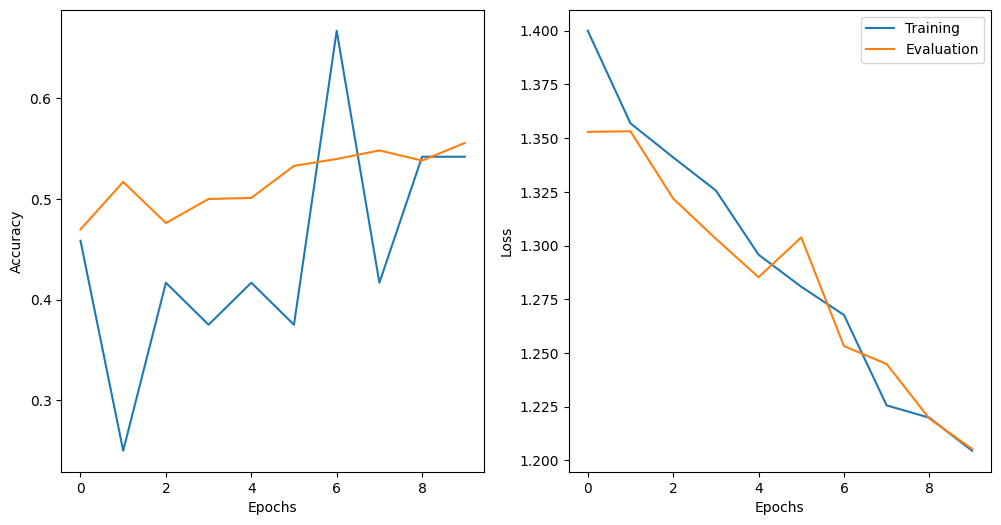

In [30]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()


plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)